## Final Project:  Wikispeedia
#### Summer 2021
**Authors:** GOAT Team (Estaban Aramayo, Ethan Haley, Claire Meyer, and Tyler Frankenberg)

### Background

Wikispeedia is a game where you navigate through a microcosm ("subgraph", in our terms) of Wikipedia.org by clicking on page links, given a source and target, and attempting to find the shortest path.  The best way to understand it is to play it, so you might as well spend one minute doing so [here](https://dlab.epfl.ch/wikispeedia/play/).

Whether the game was conceived purely for the fun of the players or whether researchers were looking for interesting data, we're glad to be able to analyze what's available at [this Stanford University site](https://snap.stanford.edu/data/wikispeedia.html), for our Final Project for CUNY MSDS 620.

### Approach

- Load, clean, and parse the provided files
  - 4600 Wikipedia articles, by name, with accompanying text
  - All links from one article to another
  - Article categories
  - Paths (sequences of links) taken by players of the game
  - Pre-computed optimal path lengths for every pair of articles
- Compute semantic distance between every pair of articles
  - Use nltk with stemmers to encode article word counts in numeric tfidf vectors
  - Explore metrics for comparing tfidf vectors
  - Train Doc2Vec to encode article meanings in numeric vectors
- Build a directed graph with networkx, to represent Wikispeedia
 - 4600 articles as nodes
 - 120K links as edges from page containing link to linked page
   - Edge attributes appropriate for analysis
- Explore and analyze everything above
 - Visualize graph structures
   - gephi
   - networkx
   - matplotlib.pyplot
 - Design custom metrics
 - Use standard graph metrics
 - Interpret results
   - Compare optimal paths to actual paths
   - Summarize graph metrics

In order to improve the readability of this notebook, we'll link to various other notebooks that were used as building blocks along the way, and simply load the end results of those building blocks into this notebook.

### Build a graph with useful structure and attributes

[In this notebook](https://github.com/ebhtra/gory-graph/blob/main/Wikispeedia/GOAT_final_project.ipynb) we took care of the data processing steps, and [In this one](https://github.com/ebhtra/gorygraph/blob/main/Wikispeedia/DocSim.ipynb) we computed various ways of comparing articles semantically.

What that left us with was **the central idea of our project's structure:**  Wikipedia can be represented as a network of topic pages, connected to each other by hyperlinks and by a latent semantic similarity that can be represented numerically.

In [1]:
import pandas as pd
linksDF = pd.read_csv('https://raw.githubusercontent.com/ebhtra/gory-graph/main/Wikispeedia/linksDF.csv', index_col=0)
linksDF.head()

,linkSource,linkTarget,cosDist,doc2vecDist
0,Áedán_mac_Gabráin,Bede,0.906869,0.626857
1,Áedán_mac_Gabráin,Columba,0.771878,0.376003
2,Áedán_mac_Gabráin,Dál_Riata,0.540850,0.214946
3,Áedán_mac_Gabráin,Great_Britain,0.886619,0.621423
4,Áedán_mac_Gabráin,Ireland,0.889658,0.665878


The `cosDist` column has the cosine distance (1 - cosine similarity) between the `linkSource` and `linkTarget` Wikipedia article vectors.  Those articles were first vectorized by removing stopwords and numbers, stemming with nltk's `SnowballStemmer`, which differentiated between articles slightly better than `PorterStemmer` did, and then normalizing via TfIdf over the Wikispedia corpus.  The `doc2vecDist` column holds the cosine distances between gensim's [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) embeddings of each article, learned by training a Doc2Vec model on similarly cleaned versions of the articles.

We'll use the Doc2Vec distances primarily, moving forward, since they differentiate better between articles.

In [2]:
import matplotlib.pyplot as plt

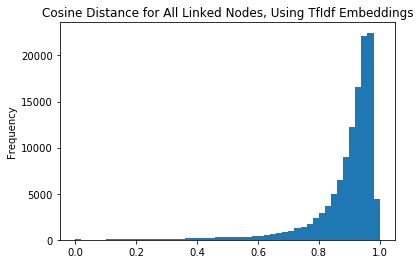

In [3]:
linksDF.cosDist.plot(kind='hist', bins=50)
plt.title('Cosine Distance for All Linked Nodes, Using TfIdf Embeddings');

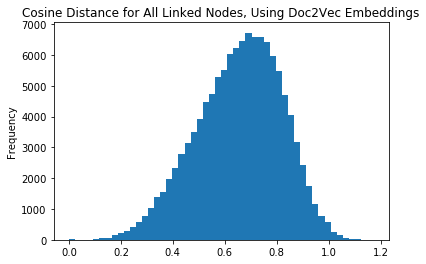

In [4]:
linksDF.doc2vecDist.plot(kind='hist', bins=50)
plt.title('Cosine Distance for All Linked Nodes, Using Doc2Vec Embeddings');

Anytime you see something like a cosine distance over 1.0, when the articles are linked, and theoretically similar, it's good to check why, either for debugging or for enlightenment.

In [5]:
linksDF.sort_values('doc2vecDist').tail(10)

,linkSource,linkTarget,cosDist,doc2vecDist
28083,Crossbill,20th_century,0.984978,1.118646
67771,Lyme_disease,Sweden,0.977642,1.119146
50713,History_of_Wikipedia,18th_century,0.955413,1.121397
97894,Sheffield,Cholera,0.981395,1.122270
10676,Attack_on_Pearl_Harbor,Europe,0.946313,1.131722
67332,Louis_Armstrong,Asia,0.979972,1.133606
44513,Glasgow,Armadillo,0.990238,1.143975
14930,Bette_Davis,Europe,0.972202,1.151904
76538,Myxobolus_cerebralis,Lebanon,0.976424,1.161943
58041,"James_T._Aubrey,_Jr.",Europe,0.983260,1.171509


The articles are indeed unrelated, as corroborated by the high TfIdf cosine distances, but after you've seen enough of Wikipedia's seemingly unrelated links, `Lyme_disease` linking to `Sweden` doesn't seem like something terribly unusual.  These are just examples of the article text unintentionally fooling Doc2Vec.

**Besides article similarity, the other important concept to us was that of how "general" a topic was. We started by using `nltk.corpus.wordnet.synset(TOPIC).min_depth` for each TOPIC, but Wikipedia is too focused on named entities to fit well with nltk's synsets (When nltk didn't have 'Eminem', we knew we should move on).**  

**The Wikispeedia graph turns out to be a small world, where every article is reachable in a relatively small number of steps/links, no matter which other article you start from.  This trait follows from the fact that there are many topics which are extremely general.  Spatially, they appear as big countries (particularly those whose inhabitants are responsible for the bulk of Wikipedia's content), temporally they appear in the form of centuries, and conceptually they appear as Science, History, Nature, Religion, etc.  Wikipedia articles are somewhat similar in size, as compared to how important their topics are, such that Science gets less room for text than does Microscope, relative to their level of generality.  Thus Science has a relatively huge ratio of in-links to out-links, compared to Microscope, and we'll use that ratio as a telling indicator of what might otherwise be difficult to measure:  Generality.**

[In this notebook](https://github.com/ebhtra/gory-graph/blob/main/Wikispeedia/DegreeRatio.ipynb) we calculated the ratio of in-degree to out-degree for each topic, and will refer to it as "generality".

In [6]:
degreeDF = pd.read_csv('degreeDF.csv', index_col=0)

print('Most general nodes in the network:')
degreeDF.sort_values('generality', ascending=False).head(10)

Most general nodes in the network:


,topic,in_dgr,out_dgr,generality
3395,Chordate,338,8,42.250000
1751,Binomial_nomenclature,295,12,24.583333
496,Scientific_classification,519,25,20.760000
1960,Climate,138,8,17.250000
3021,Animal,492,29,16.965517
1234,DVD,63,4,15.750000
2912,Latin,443,29,15.275862
3680,Gas,72,5,14.400000
880,Cultivar,41,3,13.666667
4483,Currency,291,22,13.227273


One thing that stands out is the large deviation to the upside in this top ten generality group.  Since every link leads out from one topic and in to another, generality should tend to be around 1. 

In [7]:
print(f'The mean generality for nodes in this graph is {round(degreeDF.generality.mean(),3)} and the median is {round(degreeDF.generality.median(),3)}')

The mean generality for nodes in this graph is 0.859 and the median is 0.471


Since that's so right-skewed, we'll use median instead of mean, later on.

Now onto the networkx graph.

In [8]:
import networkx as nx
# quick lookup table for node attr (generality of node topic)
gens = {top:gen for top,gen in zip(degreeDF.topic, degreeDF.generality)}
# all link ends
linknames = set(linksDF.linkSource).union(set(linksDF.linkTarget))

DG = nx.DiGraph()
for topic in linknames:
    # topics with no out degrees don't have generality scores yet.  Set to 0.
    if topic not in gens: gens[topic]=0
    DG.add_node(topic, gen=gens[topic])
for s, t, d in zip(linksDF.linkSource, linksDF.linkTarget, linksDF.doc2vecDist):
    delta_gen = gens[t] # store how clicking the link changes the generality
    DG.add_edge(s, t, d2v=d, d_gen=gens[t]-gens[s])

In [9]:
print(nx.info(DG))

Name: 
Type: DiGraph
Number of nodes: 4592
Number of edges: 119882
Average in degree:  26.1067
Average out degree:  26.1067


This graph is very connected, at 26 in and 26 out per node.

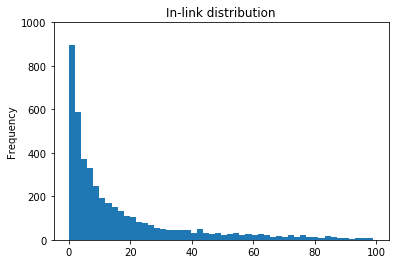

In [10]:
degreeDF[degreeDF.in_dgr < 100].in_dgr.plot(kind='hist', bins=50)
plt.title('In-link distribution')
plt.ylim(0,1000);

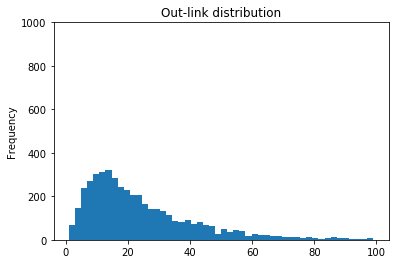

In [11]:
degreeDF[degreeDF.out_dgr < 100].out_dgr.plot(kind='hist', bins=50)
plt.title('Out-link distribution')
plt.ylim(0,1000);

These charts enforce the generality concepts discussed above:  There are a huge number of topics that get linked to from everything in the universe.  But since an article is only expected to dig into related subjects without writing a 1000-page book, the out-link distribution is much more uniform.

As far as the article categories, we were handed a hierarchical list of them for each article and display the most general one for each below.

In [12]:
categories = pd.read_csv('https://raw.githubusercontent.com/ebhtra/gory-graph/main/Wikispeedia/wikiCategories.csv', index_col=0)
categories.head()

,article,cat0,cat1,cat2
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,NaN
2,Åland,Countries,NaN,NaN
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,NaN


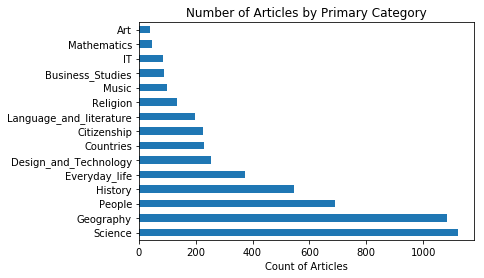

In [13]:
categories.cat0.value_counts().plot(kind='barh')
plt.xlabel('Count of Articles')
plt.title('Number of Articles by Primary Category');

**The graph is way too connected/dense to visualize as a whole, but we can choose a topic with somewhat normal generality and zoom in on it by building an ego subgraph centered on it.  We arbitrarily chose Pompeii, which turns out to be more general than the average topic, but still worth inspecting, or maybe even more worth inspecting to illustrate our concept of generality.**

As a reminder of the graph we built above:

In [14]:
DG.node['France'] # Generality of France is very high

{'gen': 11.282352941176471}

In [15]:
DG.edge['France']['Paris']

{'d2v': 0.3606382791996672, 'd_gen': -8.532352941176471}

**Paris is less general than France, as evidenced by the `d_gen` attribute being -8.5 when moving from France to Paris.  The Doc2Vec distance between Paris and France is of course small, so 0.36 is low.**

In [16]:
DG['Pompeii']  # links from Pompeii to these 13.  Pompeii itself has 23 topics linking into it (some of them these)

{'1st_century': {'d2v': 0.7858200710957813, 'd_gen': -0.525987525987526},
 'Ancient_Rome': {'d2v': 0.5553679442127262, 'd_gen': 0.2875874125874125},
 'Archaeology': {'d2v': 0.6455686268960943, 'd_gen': 0.02146690518783556},
 'BBC': {'d2v': 0.8448764072825363, 'd_gen': 2.555769230769231},
 'Drought': {'d2v': 0.7905698660449316, 'd_gen': 1.764102564102564},
 'Earthquake': {'d2v': 0.8676231723336092, 'd_gen': 2.5807692307692305},
 'Great_Britain': {'d2v': 0.9272456481169232, 'd_gen': 3.373626373626374},
 'Greece': {'d2v': 0.7116976838841338, 'd_gen': 0.38866396761133615},
 'Italy': {'d2v': 0.6197929368858993, 'd_gen': 4.701357466063349},
 'Latin': {'d2v': 0.6359986031936685, 'd_gen': 13.50663129973475},
 'Mount_Vesuvius': {'d2v': 0.3994719493645049, 'd_gen': -1.5292307692307692},
 'Volcano': {'d2v': 0.7033479267248763, 'd_gen': 0.15614236509758928},
 'World_Heritage_Site': {'d2v': 0.8588057016025433,
  'd_gen': -0.16208791208791196}}

In [17]:
pompeii = nx.ego_graph(DG, 'Pompeii', radius=2, undirected=True, distance=None) # using path steps as distance
pompeii.number_of_nodes()

1962

Pompeii has 23 in-links and 13 out-links, but each of those 36 connections (or fewer, since some point back at Pompeii) adds so many other nodes that we get to 1962 very fast.  For better viewing, let's shrink that down to the first 36 only, and then afterwards we'll try using doc2vec distance as the metric and see how many more nodes we add, since those distances are less than 1 usually.

In [18]:
pompeii = nx.ego_graph(DG, 'Pompeii', radius=1, undirected=True, distance=None) # using path steps as distance
pompeii.number_of_nodes()

34

**Here's the smaller ego graph, showing all topics one step away from Pompeii, in both directions.  The larger the node, the more general of a score it has in the Wikispeedia graph, i.e. the more in-links it has compared to out-links.  The colors of the nodes and edges are darker red when the topic has a closer semantic similarity to Pompeii, according to the cosine distances generated from our Doc2Vec embeddings.**

![Pompeii](https://raw.githubusercontent.com/ebhtra/gory-graph/main/Wikispeedia/images/pompeii.svg)

**It's clear from this smaller graph that the lighter nodes, i.e. the topics that are less semantically close to Pompeii, are pointing to Pompeii, without Pompeii linking back.  The topics that Pompeii tends to point to, on the other hand, tend to be more closely related to it (darker hued).  There's no reason that asymmetry should necessarily occur, other than if Pompeii is more general of a topic than the nodes that point to it.**

**Pompeii is much more general than the median topic, but the topics nearby it also tend to be more general, as evidenced by the fact that nodes linking to it yet not being particularly close to it semantically, such as Literacy, Advertising, Lemon, and Book, are similar to it in terms of size.**

Here we extend the radius not by increasing it from 1, but by measuring distance by Doc2Vec distance between nodes, which was less than 1 for the most part.  So we'll see "alters of alter egos" when the topics are similar enough.

In [19]:
pompeiier = nx.ego_graph(DG, 'Pompeii', radius=1, undirected=True, distance='d2v')
pompeiier.number_of_nodes()

73

**This larger graph gets cluttered fast, being so connected. There are twice as many topics, since any node that can be reached by clicking on links that sum up to less than the radius of 1 are included.**

![pompeiier](https://raw.githubusercontent.com/ebhtra/gory-graph/main/Wikispeedia/images/pompeiier.svg)

**This brings a couple of broader topics into the mix, with Spain and Portugal now on the radar, by virtue of being very closely related to topics Pompeii is very closely related to (Italy and Latin, e.g.).  There are also a lot of more specific nodes within reach now as well, for the same reason (individual Roman emperors, e.g.).  Most of those smaller nodes are still closely related to the text of Pompeii, as seen by their medium hues, yet they simply don't happen to be linked directly to Pompeii, since larger topics like "Italy" are more convenient links for Wiki-historians.**

### Graph centrality metrics

As far as pure numbers go, we'll take a look at some of the centralities now.

In [58]:
summary_df = pd.read_csv('https://raw.githubusercontent.com/ebhtra/gory-graph/main/Wikispeedia/summaryDF.csv', index_col=0)


print('\n\n================== Most Central Pages ================\n\n')
summary_df.sort_values(by='Sum Centrality', ascending=False)



================== Most Central Pages ================




,GroupID,Degree Centrality,Closeness,Betweenness,Sum Centrality
6,United_States,0.401873,0.355281,0.094090,0.851245
11,United_Kingdom,0.248312,0.338741,0.042384,0.629437
10,Europe,0.237857,0.333347,0.026992,0.598195
2,England,0.201046,0.331894,0.032403,0.565343
15,France,0.227401,0.317500,0.012002,0.556903
8,Germany,0.198650,0.336069,0.019409,0.554128
20,World_War_II,0.189501,0.319284,0.015500,0.524285
19,Africa,0.150076,0.336575,0.024204,0.510855
3,English_language,0.155957,0.321463,0.014041,0.491461
22,Japan,0.146156,0.324170,0.012973,0.483299


We see there which topics are going to appear on many shortest paths.  Primarily it's geographic entities (again, especially the Wikipedia-centric ones), and then some recent centuries, Water, and then Driving_on_the_left_or_right. The latter is a classic example of what we call a specific topic. It will have a really low in-degree to out-degree ratio, since almost no articles are interested in linking to it, yet it presumably points at a global list of countries.  That's why its closeness is high (it can lead you to anywhere, as long as you start at it) yet it has no betweenness (You can't actually get to it).  It's like a skeleton key that's locked in a box that only it opens.

In [59]:
degreeDF[degreeDF.topic == 'Driving_on_the_left_or_right']

,topic,in_dgr,out_dgr,generality
304,Driving_on_the_left_or_right,0,255,0.0


### We'll finish by analyzing paths people took and comparing them to optimal (shortest) ones.

In [24]:
# Get all paths taken successfully
allPaths = pd.read_csv('https://raw.githubusercontent.com/ebhtra/gory-graph/main/Wikispeedia/allPathsDF.csv', index_col=0)
# pandas reads a tuple as a string literal, so we need to un-literal it back in to a tuple
import ast
allPaths['from_to'] = [ast.literal_eval(tup) for tup in allPaths.from_to]
allPaths.head(2)

,from_to,doc2vecDist,num_times,avg_length,min_length
0,"(14th_century, African_slave_trade)",0.61065,3,6.333,4
1,"(15th_century, African_slave_trade)",0.74161,1,7.000,7


In [25]:
allPaths.shape

(140968, 5)

Those 140K rows show where a graph navigator was in relation to her target (`from_to`), what the semantic distance was between source and target (`doc2vecDist`), how many times that source-target pair got completed, and what were the average and minimum number of clicks used to complete the navigation.

Theoretically, the semantic distance should be more closely correlated with the minimum length, which represents some sort of ideal, rather than the average length, which represents people acting less predictably.  Maybe.

In [26]:
from scipy.stats import pearsonr

Correlation between average path length taken and semantic distance of source and target articles:

In [27]:
pearsonr(allPaths.doc2vecDist, allPaths.avg_length)

(0.08549367684556834, 6.869763708482339e-227)

And for the shortest path humans chose:

In [28]:
pearsonr(allPaths.doc2vecDist, allPaths.min_length)

(0.08729703177692182, 1.651467254221046e-236)

The correlation is actually statistically the same for the two, and is real but small.
Most likely, if we add an optimal path column to the frame, we'll find a higher correlation still.  First we need to get the shortest paths though.

In [29]:
SP = []
for (s, t), min_p in zip(allPaths.from_to, allPaths.min_length):
    try:
        SP.append(nx.shortest_path_length(DG, s, t, weight=None)) # No weight == links clicked
    except nx.NetworkXNoPath:
        SP.append(min_p)

In [30]:
allPaths['SP'] = SP
allPaths.head(2)

,from_to,doc2vecDist,num_times,avg_length,min_length,SP
0,"(14th_century, African_slave_trade)",0.61065,3,6.333,4,3
1,"(15th_century, African_slave_trade)",0.74161,1,7.000,7,3


Correlation between optimal path length and semantic distance from source to target:

In [31]:
pearsonr(allPaths.doc2vecDist, allPaths.SP)

(0.47380683016254915, 0.0)

#### **It's fun to think that the minimum shortest paths people take through the graph could somehow imply a truer measure of semantic distance between source and target, but the optimal paths are just so much more correlated with the Doc2Vec embeddings (0.47 vs 0.09) that it's hard to hang on to that notion.  The problem for us humans is that we rely on a greedy algorithm approach, where we only see the links in front of us on the current page, without knowing what links future pages will offer. The shortest paths algorithms start with the entire catalog of links and optimize a path accordingly.**

#### Explore the trajectory of paths, both optimal and actual, in terms of generality and semantics

Let's start by sampling from a common shortest path length, 4.

In [32]:
fours = allPaths[allPaths.SP==4]
fours.head()

,from_to,doc2vecDist,num_times,avg_length,min_length,SP
76,"(Climate, Rainbow)",0.76443,3,6.667,4,4
160,"(2004_Atlantic_hurricane_season, Buckminster_F...",0.88366,1,9.000,9,4
161,"(U.S._state, Buckminster_Fuller)",0.94091,1,8.000,8,4
170,"(Atlantic_Ocean, Great_comet)",0.71457,1,7.000,7,4
171,"(Tropical_cyclone, Great_comet)",0.66922,1,6.000,6,4


Let's inspect (Climate->Rainbow), although we still need to get all the completed paths to find which ones they occurred on--

In [33]:
import numpy as np
paths_finished = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names = np.array(['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']), skiprows=16)
from urllib import parse
# decode UTF-8 special characters using urllib.parse.unquote()
paths_finished['path'] = paths_finished['path'].apply(lambda x: parse.unquote(x))

paths_finished.head(10)

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultravi...,NaN


Let's just keep all the paths, as lists.

In [34]:
paths_finished = [path.split(';') for path in paths_finished.path]
len(paths_finished)

51318

For quicker lookup, we'll make a dictionary with (source, target) tuples as keys, and a list holding all the paths, for each key.

In [35]:
from collections import defaultdict

pathdict = defaultdict(list)

for path in paths_finished:
    pathdict[(path[0],path[-1])].append(path)

How many of the 51318 paths had unique source-target pairs?

In [36]:
len(pathdict)

28718

Which pair was done the most?

In [37]:
max(pathdict, key=len)

('14th_century', 'African_slave_trade')

In [66]:
len(pathdict[('14th_century', 'African_slave_trade')])

3

**So there were apparently many source-target pairs done 3 times, and that one was first alphabetically.**

In [38]:
# Let's see which paths used "Climate"-->"Rainbow" as seen above
rainbows = [p for p in paths_finished if p[-1] == "Rainbow" and 'Climate' in p]
print(len(rainbows), rainbows[1])

3 ['Space_Shuttle_Challenger', 'Space_Shuttle_Endeavour', 'International_Space_Station', 'Space_Shuttle_program', 'Star_Trek', 'Technology', 'Science', 'Nature', 'Meteorology', 'Climate', 'Tropical_cyclone', 'Rain', 'Water', 'Rainbow']


In [39]:
# details on that game:
allPaths[allPaths.from_to == ('Space_Shuttle_Challenger', 'Rainbow')]

,from_to,doc2vecDist,num_times,avg_length,min_length,SP
20991,"(Space_Shuttle_Challenger, Rainbow)",0.83563,1,13.0,13,4


That one got from Climate to Rainbow in the optimal length of 4.  Let's see an entire optimal path calculated by networkx.

In [40]:
nx.shortest_path(DG, 'Space_Shuttle_Challenger', 'Rainbow')

['Space_Shuttle_Challenger',
 'United_States',
 'Electronics',
 'Color',
 'Rainbow']

In [41]:
# and from Climate to Rainbow
nx.shortest_path(DG, 'Climate', 'Rainbow')

['Climate', 'History', 'University_of_Cambridge', 'Alan_Turing', 'Rainbow']

**This small sample of paths shows how unrelated source-target pairs must pass over a very general bridge, possibly not strongly related to either endpoint, in order to meet.  The human player spends time fishing around to get there, using Star_Trek to get to Science, and then gradually working her way through various climate subjects to get to Rainbow.  The computer goes directly to United_States, which is usually a good approach in Wikispeedia, and then to Electronics and Color.  Even if the source were Climate, the computer would jump to History first, and then  University_of_Cambridge and Alan_Turing, whereas any human would stick with meteorological concepts.**

We'll now repeat the above process with 100 randomly sampled paths of that type.  This will allow us to do some numerical analysis on potentially interesting paths.  Paths of only one or two links are less interesting, whereas source-target pairs for which the computer needs even its maximum of 6 steps aren't realistic to compare to human choices. For example:

In [42]:
allPaths = allPaths[allPaths.SP < 18] # there's one error row of SP==18
allPaths[allPaths.SP == max(allPaths.SP)]

,from_to,doc2vecDist,num_times,avg_length,min_length,SP
30288,"(Osteomalacia, Cholera)",1.06277,1,7.0,7,7


That's also an error row, as the computer doesn't have that source topic in its links list, as provided to us.

In [43]:
sixers = allPaths[allPaths.SP == 6]
print(f"There were only {len(sixers)} cases out of the 140K pairs where a computer needs even 6 steps to connect them.")
sixers.head()

There were only 31 cases out of the 140K pairs where a computer needs even 6 steps to connect them.


,from_to,doc2vecDist,num_times,avg_length,min_length,SP
4188,"(Batman, Wikisource)",0.86346,4,19.500,8,6
4207,"(Computer_science, Wikisource)",0.64762,3,20.333,13,6
11249,"(First_Macedonian_War, Upsilon_Andromedae_c)",0.83542,1,17.000,17,6
11254,"(Liberal_democracy, Upsilon_Andromedae_c)",0.83511,1,12.000,12,6
11257,"(Pre-Raphaelite_Brotherhood, Upsilon_Andromeda...",0.84369,1,9.000,9,6


Possibly this is a good moment to pause and reflect on the six degrees of separation in a small world graph like Wikispeedia.

It's apparent from a glance at that `head` that some targets (Wikisource and Upsilon_Andromedae_c) are particularly hard to get to, which will equate to having a low generality score in our calculations.  No matter where you start in Wikispeedia, you can get almost anywhere in a small number of steps, but a target that has few in-links, and maybe most of those links come from topics that themselves have few in-links, is going to be very hard to find, especially for a human. 

In [44]:
rand4 = fours.sample(100, random_state=6)  # the 100 random sample rows

In [45]:
rand4.head()

,from_to,doc2vecDist,num_times,avg_length,min_length,SP
29755,"(Age_of_Enlightenment, Sperm_Whale)",0.92214,1,5.0,5,4
109396,"(France_in_the_American_Revolutionary_War, Iri...",0.79866,1,6.0,6,4
91113,"(Gregor_Mendel, Turmeric)",0.83188,1,23.0,23,4
133465,"(Market, Asparagus)",0.85644,1,15.0,15,4
133733,"(North_Sea, Svartálfar)",0.87129,1,10.0,10,4


100 optimal paths of 4 steps:

In [46]:
algopaths = [nx.shortest_path(DG, s, t) for s,t in rand4.from_to]

Shortest paths navigated by humans for the same pairs:

In [47]:
humanpaths = []
for (s,t), minL in zip(rand4.from_to, rand4.min_length):
    # get all actual paths that ended at target and had source somewhere
    paths = [p for p in paths_finished if p[-1] == t and s in p]
    # use only the best human paths
    for path in paths:
        if path[-minL-1] == s:
            humanpaths.append(path[-minL-1:])
            break

In [48]:
print(algopaths[2])

['Gregor_Mendel', 'Physics', 'Ancient_Greece', 'Olive_oil', 'Turmeric']


In [49]:
print(humanpaths[2])

['Gregor_Mendel', 'DNA_repair', 'Cancer', 'Brain', "Alzheimer's_disease", 'Ronald_Reagan', 'United_States', 'Japan', 'Rice', '<', 'Wasabi', 'Cultivar', 'Plant', 'Seed', 'Cotton', 'Textile', 'China', 'Japan', 'Wasabi', 'Cultivar', 'Plant', 'Safflower', 'Saffron', 'Turmeric']


Notice the '<' characters in the above humanpath.

Some Wikispeedia rules disallow hitting the `back` button (shown as '<' here).  The paths in the dataset we're using result from a more lenient set of rules, which is only fair, since humans don't get as much info as computers do, as discussed above.  So we'll eliminate backspaces.

In [50]:
humanpaths = [[topic for topic in path if topic != '<'] for path in humanpaths]
print(humanpaths[2])

['Gregor_Mendel', 'DNA_repair', 'Cancer', 'Brain', "Alzheimer's_disease", 'Ronald_Reagan', 'United_States', 'Japan', 'Rice', 'Wasabi', 'Cultivar', 'Plant', 'Seed', 'Cotton', 'Textile', 'China', 'Japan', 'Wasabi', 'Cultivar', 'Plant', 'Safflower', 'Saffron', 'Turmeric']


#### Now collect the numbers we want for each path:  Generality of each node along the way and semantic distance for each link used.

In [51]:
# use the lookup table we made earlier for generality
algogens = [[gens[topic] for topic in path] for path in algopaths]
humangens = [[gens[topic] for topic in path] for path in humanpaths]

In [52]:
# use graph edge attributes for linksims
algosims = [[DG.edge[path[i]][path[i+1]]['d2v'] for i in range(len(path)-1)] for path in algopaths]

In [53]:
humansims = []
for path in humanpaths:
    sims = []
    for i in range(len(path)-1):
        try:
            sims.append(DG.edge[path[i]][path[i+1]]['d2v'])
        except KeyError:
            sims.append(0.5)
    humansims.append(sims)

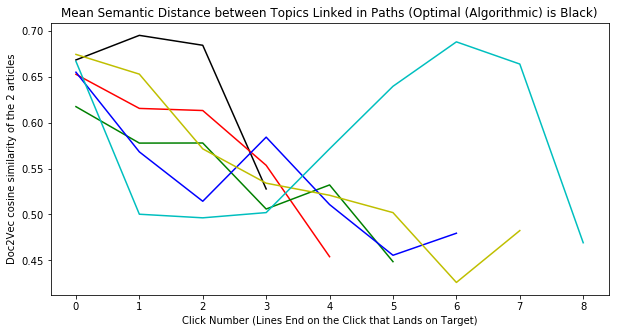

In [54]:
meanAlgoSims = np.mean(np.array(algosims), axis=0)

plt.figure(figsize=(10,5))
plt.plot(meanAlgoSims, color='k')
colors = list('rgbyc')
for i in range(5,10):
    plt.plot(np.mean(np.array([h for h in humansims if len(h) == i]), axis=0), color=colors[i-5])
plt.title('Mean Semantic Distance between Topics Linked in Paths (Optimal (Algorithmic) is Black)')
plt.ylabel('Doc2Vec cosine similarity of the 2 articles')
plt.xlabel('Click Number (Lines End on the Click that Lands on Target)');

You can see that the algorithm spends clicks 2 and 3 moving between topics that are further away in semantic meaning compared to people, who move between more similar articles.  Once again, this is not necessarily due to the way we perceive meanings so much as the fact that we are unaware of what we'll be presented with 2 steps ahead, so we proceed more cautiously.  We get to a semantic distance of 0.45-0.48 and click home to the target from there.  The computer clicks home from about 0.53, the level at which we are surprised to find that the link we expected to lead us home does not exist (see yellow, green, blue, and cyan lines at clicks 2-5).

#### Now let's check the same chart for generality

In [55]:
# Use median instead of mean, since the standard deviation is much larger
medianAlgoGens = np.median(np.array(algogens), axis=0)

medianAlgoGens

array([1.23529412, 1.81052632, 1.60759908, 0.91589862, 0.41052632])

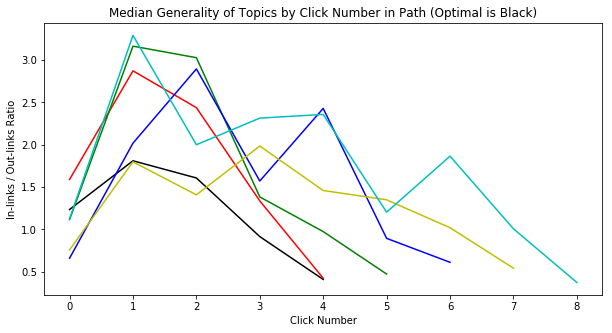

In [56]:
plt.figure(figsize=(10,5))
plt.plot(medianAlgoGens, color='k')
colors = list('rgbyc')
for i in range(5,10):
    plt.plot(np.median(np.array([h for h in humangens if len(h) == i]), axis=0), color=colors[i-5])
plt.title('Median Generality of Topics by Click Number in Path (Optimal is Black)')
plt.ylabel('In-links / Out-links Ratio')
plt.xlabel('Click Number');

**We see the overall expected small-world pattern of moving to general topics as soon as you can, and then spending the majority of the solution path clicking on increasingly specific topics.  This is partly because we know these general topics provide us a gateway to the world, but also because there are simply more links leading to these topics, by our definition of generality.  If you feel like you usually pick the wrong line at the store checkout, it's because you actually pick right half the time, but spend more time thinking about it when you're in the longer line, by definition.**